In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import numpy as np
import pandas as pd

import json

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH          = r"hess_paper_output"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

# PBHM residuals test on Gaussianity and homocedaticity 

In [3]:
# load data
df = pd.read_csv(DATA_PATH)
df.set_index("time", inplace=True)

# calc pbhm residuals
y  = np.expand_dims(df["qmeasval"].values, axis=1)
yp = np.expand_dims(df["qsim"].values, axis=1)
res = yp - y

# box cox transform
y_boxcox   = stats.boxcox(y, lmbda = 0.2)
res_boxcox = stats.boxcox(yp, lmbda = 0.2) - y_boxcox


# compute statistics
print("computing statistics")
rst_gof  = stats.goodness_of_fit(stats.norm,
                                 res[:,0], 
                                 statistic="filliben", 
                                 n_mc_samples=1000,
                                )
filliben = rst_gof.statistic

exog      = np.append(np.ones_like(y), y, axis=1)
rst_het   = het_breuschpagan(res, exog)
het_lm    = rst_het[0]
het_fstat = rst_het[2]

# boxcox transformed
rst_gof_boxcox  = stats.goodness_of_fit(stats.norm,
                                 res_boxcox[:,0], 
                                 statistic="filliben", 
                                 n_mc_samples=1000, 
                                )
filliben_boxcox = rst_gof_boxcox.statistic

exog_boxcox      = np.append(np.ones_like(y), stats.boxcox(y, lmbda = 0.2), axis=1)
rst_het_boxcox   = het_breuschpagan(res_boxcox, exog_boxcox)
het_lm_boxcox    = rst_het_boxcox[0]
het_fstat_boxcox = rst_het_boxcox[2]

computing statistics


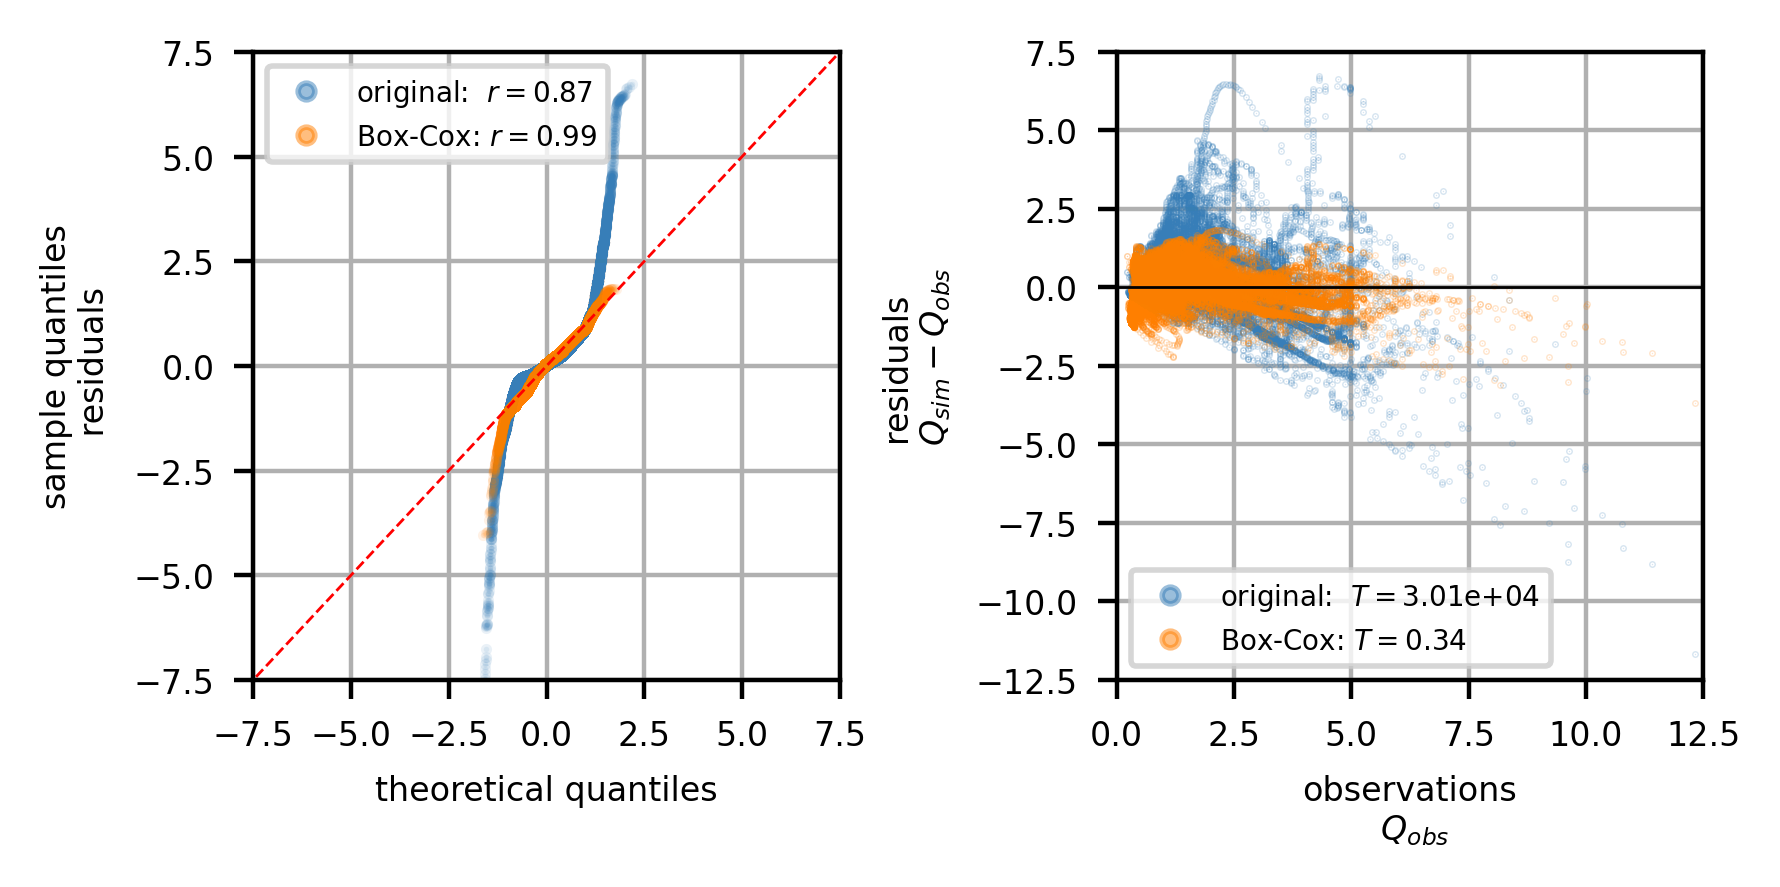

In [4]:
# plot
fig1, axes = plt.subplots(1,2,figsize=(4.72,2.2), dpi=400)

color_res    = '#377eb8'
color_boxcox = '#ff7f00'

sm.qqplot(res[:,0], 
          dist=stats.norm(res[:,0].mean(), 
                          res[:,0].std()),
          ax=axes[0], 
          markersize=1, 
          markerfacecolor=color_res,
          markeredgecolor=color_res,
          alpha=0.1,
          label="original:  $r = $" + f"{filliben:.2g}",
         )
sm.qqplot(res_boxcox[:,0],
          dist=stats.norm(res_boxcox[:,0].mean(), 
                          res_boxcox[:,0].std()),
          ax=axes[0], 
          markersize=1, 
          markerfacecolor=color_boxcox,
          markeredgecolor=color_boxcox,
          alpha=0.1,
          label="Box-Cox: $r = $" + f"{filliben_boxcox:.2g}",
         )

axes[0].plot([-10,10],[-10,10], 'r--', linewidth=0.5)

axes[0].grid(True)
axes[0].set_xticks(np.arange(-10,11,2.5))
axes[0].set_yticks(np.arange(-10,11,2.5))
axes[0].set_xlim((-7.5,7.5))
axes[0].set_ylim((-7.5,7.5))
axes[0].set_xlabel("theoretical quantiles")
axes[0].set_ylabel("sample quantiles\n residuals")

    

horig = axes[1].plot(y, res, marker=".", ls="None",
               markersize=0.5, alpha=0.2, color=color_res,
               label="original:  $T = $" + f"{het_lm:.3g}",
              )

hboxcox = axes[1].plot(y, res_boxcox, marker=".", ls="None",
               markersize=0.5, alpha=0.2, color=color_boxcox,
               label="Box-Cox: $T = $" + f"{het_lm_boxcox:.3g}",
              )


axes[1].grid(True)
axes[1].axhline(0, color="k", lw=0.5)
axes[1].set_xticks(np.arange(0,13,2.5))
axes[1].set_yticks(np.arange(-12.5,7.6,2.5))
axes[1].set_xlim((0,12.5))
axes[1].set_ylim((-12.5,7.5))
axes[1].set_xlabel("observations\n $Q_{obs}$")
axes[1].set_ylabel("residuals\n  $Q_{sim}-Q_{obs}$")

fig1.tight_layout()
plt.subplots_adjust(right=0.9)
lgd_0 = axes[0].legend(loc="upper left", fontsize=5) 
for h in lgd_0.legend_handles:
    h.set_markersize(3)
    h.set_alpha(0.5)
    
lgd_1 = axes[1].legend(loc="lower left", fontsize=5) 
for h in lgd_1.legend_handles:
    h.set_markersize(6)
    h.set_alpha(0.5)

In [5]:
fig1.savefig(os.path.join(PLOT_PATH, 'figA1_residuals_pbhm.png'), dpi=300, bbox_inches='tight')

In [6]:
# critical value Bresch-Pagan-Test based on chi2 distibution
alpha = 0.05
degrees_of_freedom = 1
critical_value = stats.chi2.ppf(1 - alpha, degrees_of_freedom)
critical_value

3.841458820694124

# Autocorrelation functions

In [8]:
nlags = 100 #  num of lags to analyse
dfcf = pd.DataFrame(index=pd.MultiIndex(levels=[[], [], np.arange(nlags+1)], 
                                      codes=[[], [], []], 
                                      names=["transform", "year", "lag"],
                                     ),
                  columns = ["acf_value", "acf_bound", "pacf_value", "pacf_bound"],
                 )
res         = {"orig":[], "boxcox":[], "diff":[]}
colors      = {"orig"  :'#377eb8',
               "boxcox":'#ff7f00',
               "diff"  :'#e41a1c',
              }

# bootstrapping residuals for each year from 2011 to 2017
for year in range(2011,2018):
    print(year)
    mask = pd.to_datetime(df.index).year == year
        
    # calc pbhm residuals per year
    y  = np.expand_dims(df.loc[mask, "qmeasval"].values, axis=1)
    yp = np.expand_dims(df.loc[mask, "qsim"].values, axis=1)
    res["orig"] = yp[:,0] - y[:,0]
    
    # box cox transform
    y_boxcox   = stats.boxcox(y[:,0], lmbda = 0.2)
    res["boxcox"] = stats.boxcox(yp[:,0], lmbda = 0.2) - y_boxcox

    # 1st differentiated
    res["diff"] = np.diff(res["boxcox"])

    for key, item in res.items():
        acf_values, acf_bounds = acf(item, nlags=nlags, fft=True, alpha = 0.05)
        pacf_values, pacf_bounds = pacf(item, nlags=nlags, alpha = 0.05)

        for n in range(nlags+1):
            dfcf.loc[(key, year, n), :] = [acf_values[n], np.abs(acf_bounds[n,0]-acf_values[n]), pacf_values[n], np.abs(pacf_bounds[n,0]-pacf_values[n])] 

2011
2012
2013
2014
2015
2016
2017


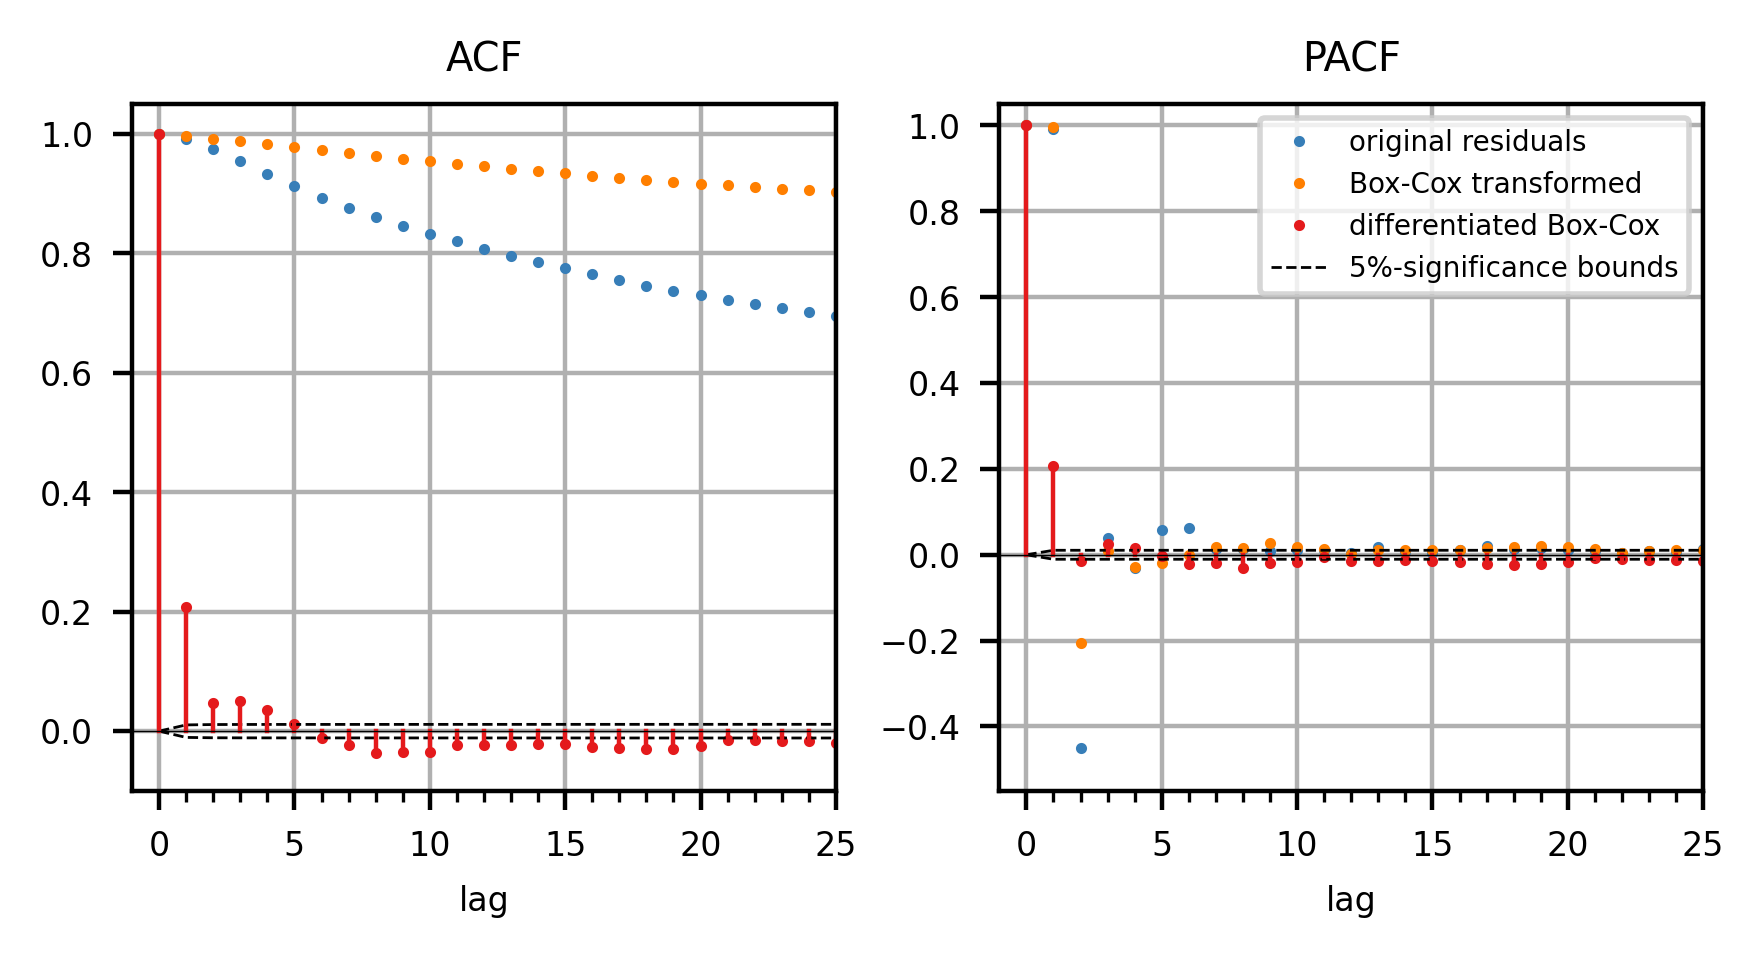

In [9]:
fig2, axes = plt.subplots(1,2,figsize=(4.72,2.5), dpi=400)

for key in res.keys():
    dfpart = dfcf.xs(key, level=0).groupby("lag").mean()
    axes[0].plot(dfpart["acf_value"], 
                 color = colors[key], ls="None", marker="o", markersize=1,
                )
    
    axes[1].plot(dfpart["pacf_value"],
                 color = colors[key], ls="None", marker="o", markersize=1,
                )

    if key == "diff": # plot bounds and vertical lines for differentiated only
        axes[0].plot(dfpart["acf_bound"], 
                     color = 'k', linestyle = '--', lw=0.5,
                     label = "5% significance bounds"
                    )
        axes[0].plot(dfpart["acf_bound"] * -1, 
                     color = 'k', linestyle = '--', lw=0.5,
                    )
        axes[1].plot(dfpart["pacf_bound"], 
                     color = 'k', linestyle = '--', lw=0.5,
                    )
        axes[1].plot(dfpart["pacf_bound"] * -1,
                     color = 'k', linestyle = '--', lw=0.5,
                    )

        for n, value in enumerate(dfpart["acf_value"].values):
            axes[0].plot([n,n], [0,value], color = colors[key], lw=0.8)
            
        for n, value in enumerate(dfpart["pacf_value"].values):
            axes[1].plot([n,n], [0,value], color = colors[key], lw=0.8)


axes[0].set_xlim((-1,25))
axes[1].set_xlim((-1,25))
axes[0].set_ylim((-0.1,1.05))
axes[1].set_ylim((-0.55,1.05))
axes[0].grid()
axes[1].grid()

axes[0].axhline(0, color="k", lw=0.25)
axes[1].axhline(0, color="k", lw=0.25)

axes[0].xaxis.set_major_locator(FixedLocator(np.arange(0,101,5)))
axes[1].xaxis.set_major_locator(FixedLocator(np.arange(0,101,5)))
axes[0].xaxis.set_minor_locator(FixedLocator(np.arange(0,101,1)))
axes[1].xaxis.set_minor_locator(FixedLocator(np.arange(0,101,1)))
axes[0].yaxis.set_major_locator(FixedLocator(np.arange(-0.6,1.1,0.2)))
axes[1].yaxis.set_major_locator(FixedLocator(np.arange(-0.6,1.1,0.2)))

axes[0].set_title("ACF")
axes[1].set_title("PACF")

axes[0].set_xlabel("lag")
axes[1].set_xlabel("lag")

lgd_handles =  [Line2D([],[], ms=1, c=colors["orig"], marker="o", ls="None"),
                Line2D([],[], ms=1, c=colors["boxcox"], marker="o", ls="None"),
                Line2D([],[], ms=1, c=colors["diff"], marker="o", ls="None"),
                Line2D([],[], c="k", lw=0.5, ls="--"),
               ]
lgd_labels = ["original residuals", "Box-Cox transformed", "differentiated Box-Cox", "5%-significance bounds"]
axes[1].legend(lgd_handles, lgd_labels, loc="upper right", fontsize=5)

fig2.tight_layout()
plt.subplots_adjust(top=0.85, right=0.9)

In [10]:
fig2.savefig(os.path.join(PLOT_PATH, 'figA2_acf_pacf_pbhm.png'), dpi=300, bbox_inches='tight')